# Predicting Women's Clothing Reviews Using Multinomial Naive Bayes

## 1. Introduction

In this project, I am interested to analyze the sentiment of women's clothing reviews using Naive Bayes Classifier. The data comes from Kaggle and includes 23486 rows and 10 feature variables. Each row corresponds to a customer review and includes the following variables as described on the website:<br>
**Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.<br>
**Age**: Positive Integer variable of the reviewers age.<br>
**Title**: String variable for the title of the review.<br>
**Review Text**: String variable for the review body.<br>
**Rating**: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.<br>
**Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.<br>
**Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.<br>
**Division Name**: Categorical name of the product high level division.<br>
**Department Name**: Categorical name of the product department name.<br>
**Class Name**: Categorical name of the product class name.<br>

The data is anonymized and the references to the company in the `Review Text` have been replaced with `retailer` because the data comes from real commercial data. In this project, I am aiming to  determine whether a product is recommended or not by analysing the sentiment of customer reviews. I will mainly focus on `Recommended IND` as my dependent variable and `Review Text` as the predictor variable.

## 2. Cleaning the Data
Before diving into predictions, it is crucial to take a deep look at the data, and take data cleaning steps if 
necessary.

In [1]:
# Importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer,ToktokTokenizer
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.naive_bayes import MultinomialNB
from string import punctuation
from nltk.stem import WordNetLemmatizer
import os
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from sklearn.linear_model import LogisticRegression
from nltk.stem import SnowballStemmer, WordNetLemmatizer, LancasterStemmer
import string

I have downloaded the data locally and uploaded back to my github repository to be able to access it easily. 

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/ayobishahana/python-text-analysis/main/Data/Womens-Clothing-E-Commerce-Reviews.csv")


In [3]:
data.head(3)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


Looking at the description below, we can see that most of the missing values come from the `Title`, however, we do not really need this column for prediction, so it can be dropped. Since the `Review Text` would be used as the main predictor, having missing values can affect the accuracy and reliability of predictions, so I will drop those few rows with NA values. 

In [4]:
print('Number of Duplicates:', data.duplicated().any())

print('Missing Values:', data.isnull().values.sum())
print('\n')
# Most of the missing values is in the director, cast and country column
print('Missing rows in each column: \n')

# Create an empty list to store the loop output
output = []

for i in data.columns:
    NA_number = data[i].isnull().sum()
    NA_rate = NA_number / len(data) * 100
    if NA_rate > 0:
        # Append the column name and loop output to the list
        output.append([i, NA_number, f"{NA_rate:.2f}%"])

# Create a dataframe from the list
df = pd.DataFrame(output, columns=["Column", "Number of Missing", "Rate of Missing"])

# Print the dataframe
print(df.to_string(index=False))
# drop the 'Unnamed: 0' and 'Title'
data= data.drop(columns=['Unnamed: 0', 'Title'])

# drop NA values from 'Review Text'
data = data.dropna(subset=['Review Text', 'Class Name'])

Number of Duplicates: False
Missing Values: 4697


Missing rows in each column: 

         Column  Number of Missing Rate of Missing
          Title               3810          16.22%
    Review Text                845           3.60%
  Division Name                 14           0.06%
Department Name                 14           0.06%
     Class Name                 14           0.06%


In [5]:
# replace spaces with underscores and lowercase the column names
data.columns = [col.lower().replace(' ', '_') for col in data.columns]
# get dimension of the data
print(data.shape)
data.head(2)

(22628, 9)


,clothing_id,age,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses


In [6]:
data.isnull().sum()

clothing_id                0
age                        0
review_text                0
rating                     0
recommended_ind            0
positive_feedback_count    0
division_name              0
department_name            0
class_name                 0
dtype: int64

## 3. Exploratory Data Analysis (EDA)

To check the distributions of some variables and make decisions based on that information, we will look at them closely. The age distribution plot reveals that the majority of buyers are in their middle years, the rating distributions reveal that the majority of the products have high ratings, and the class distribution reveals that dresses and knits are among the most popular items.

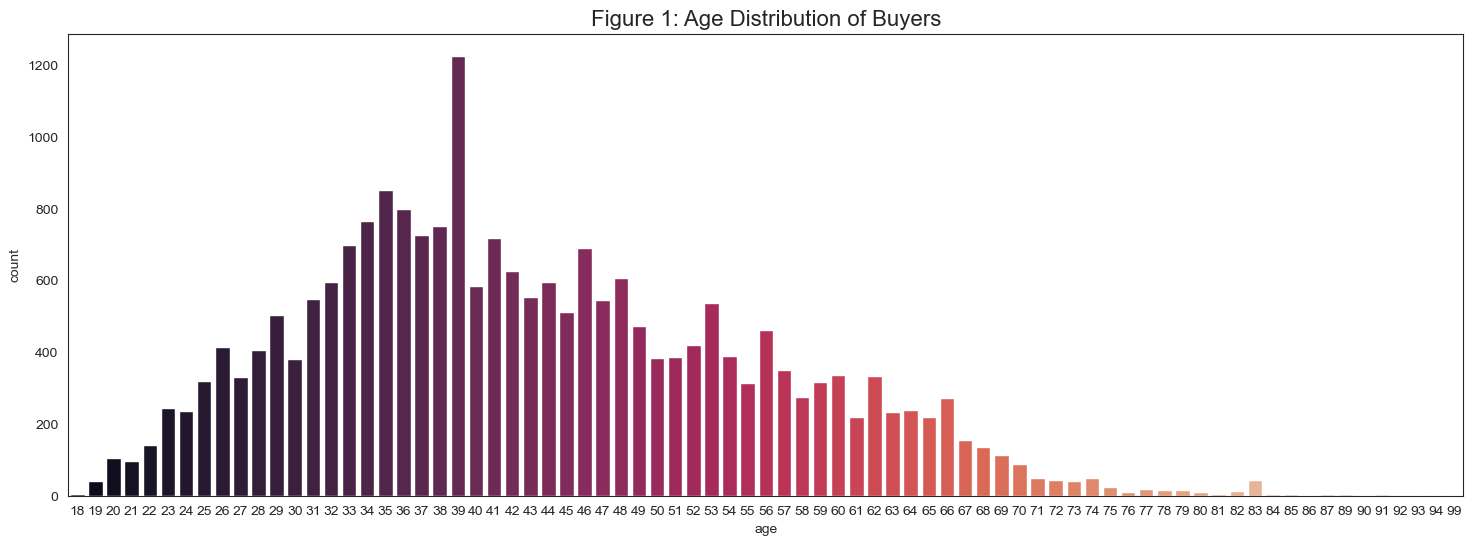

In [7]:
sns.set_style('white')
plt.figure(figsize=(18,6))
sns.countplot(x='age', data=data, palette='rocket')
plt.title('Figure 1: Age Distribution of Buyers', fontsize=16)
plt.show()


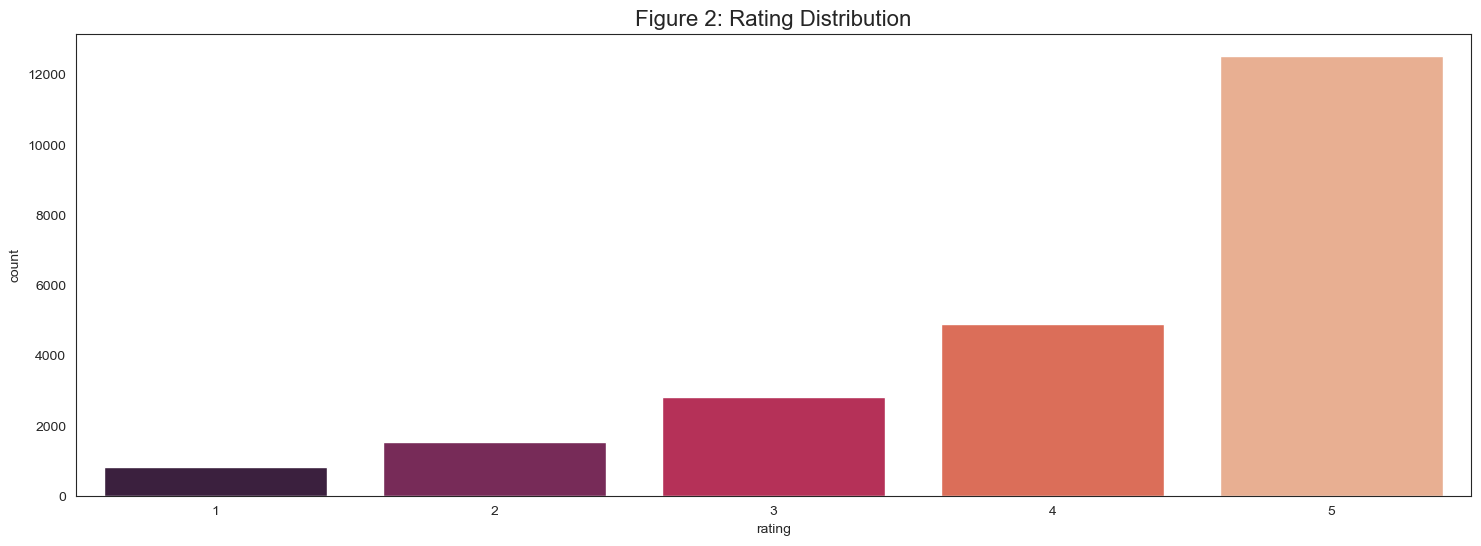

In [8]:
sns.set_style('white')
plt.figure(figsize=(18,6))
sns.countplot(x='rating', data=data, palette='rocket')
plt.title('Figure 2: Rating Distribution', fontsize=16)
plt.show()

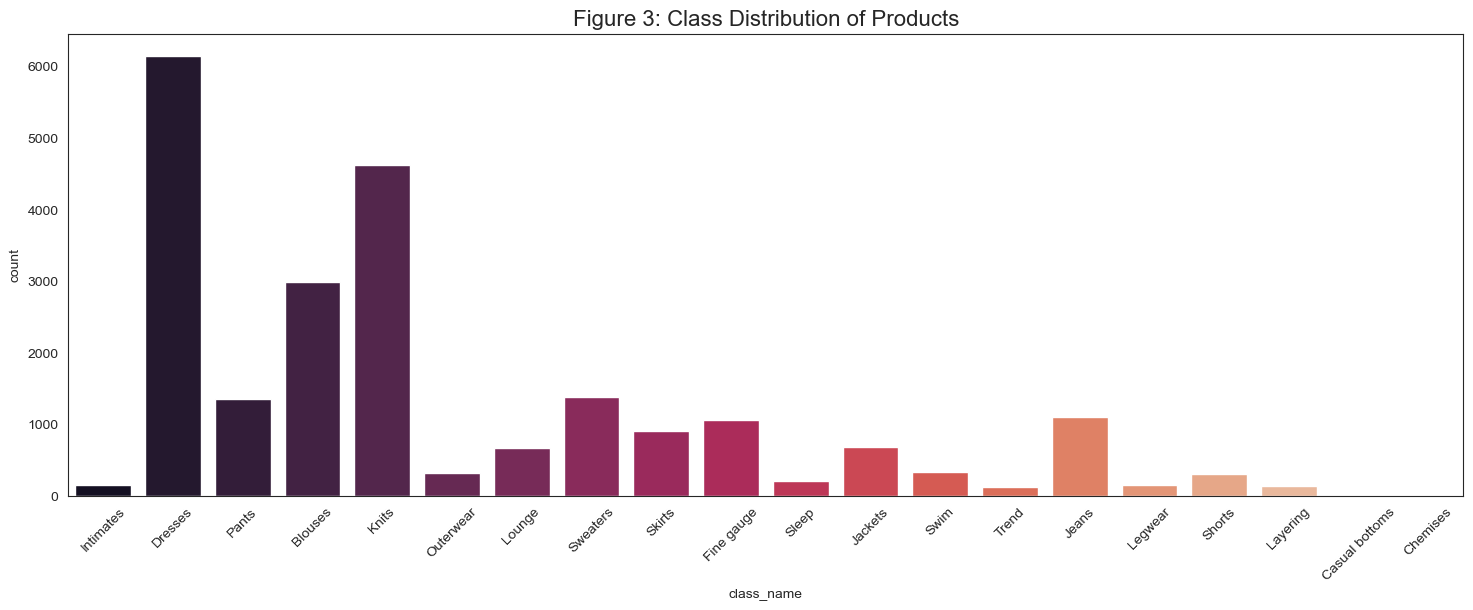

In [9]:
sns.set_style('white')
plt.figure(figsize=(18,6))
sns.countplot(x='class_name', data=data, palette='rocket')
plt.xticks(rotation=45)
plt.title('Figure 3: Class Distribution of Products', fontsize=16)
plt.show()

<h4>Renaming Target Variable Values</h4>
Instead of using 0 and 1 as values of target variable, we can use more appropiate values like "Not Recommended" and "Recommended".

In [10]:
data.loc[data["recommended_ind"] == 0, "recommended_ind"] = "Not Recommended" # 0 -> Not Recommended
data.loc[data["recommended_ind"] == 1, "recommended_ind"] = "Recommended" # 1 -> Recommended

In [11]:
data.dtypes

clothing_id                 int64
age                         int64
review_text                object
rating                      int64
recommended_ind            object
positive_feedback_count     int64
division_name              object
department_name            object
class_name                 object
dtype: object

<h4>Checking the Proportions of Target Class Variable</h4>

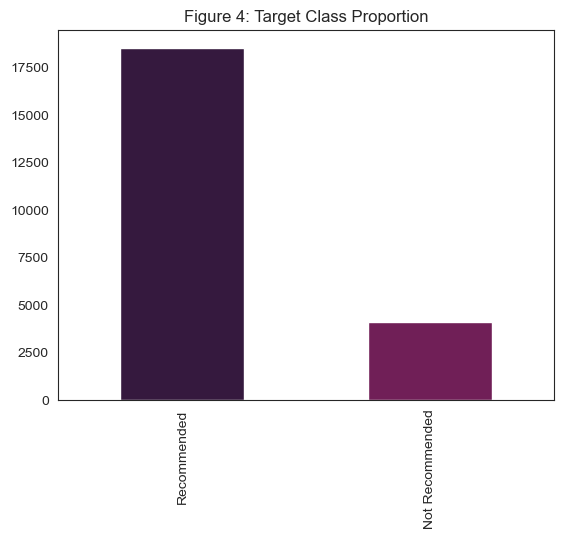

In [12]:
sns.set_style('white')
count_class = pd.value_counts(data['recommended_ind'], sort=True)
count_class.plot(kind='bar', color=sns.color_palette('rocket'))
plt.title('Figure 4: Target Class Proportion')
plt.show()

In [13]:
print('Recommended', round(data['recommended_ind'].value_counts()['Recommended']/len(data) * 100), '%')
print('Not Recommended', round(data['recommended_ind'].value_counts()['Not Recommended']/len(data) * 100), '%')

Recommended 82 %
Not Recommended 18 %


The target variable has an imbalanced proportion of classes, as seen in the plot, with "Recommended" values predominating with a proportion value of 82% and the remaining "Not Recommended" values accounting for just 18%.

<h4>Check The Most Common Words in Target Variables</h4>
The results below show the common words used for both classes of dependent variable in the `review_text` column. It is apparent that those are mainly stopwords that occur the most; therefore, before going into modeling the text should be cleaned.

In [14]:

count1 = Counter(" ".join(data[data['recommended_ind']== 'Recommended']['review_text']).\
                 split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)


In [15]:
df1 = df1.rename(columns={0: "common_words", 1 : "count"})
df1.head(10)

,common_words,count
0,the,58946
1,i,40772
2,and,40373
3,a,35823
4,it,29782
5,is,25518
6,to,19761
7,this,16673
8,in,16505
9,but,12594


In [16]:
count2 = Counter(" ".join(data[data['recommended_ind']== 'Not Recommended']['review_text']).\
                 split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)


In [17]:
df2 = df2.rename(columns={0: "common_words", 1 : "count"})
df2.head(10)

,common_words,count
0,the,15744
1,i,8841
2,and,8116
3,it,7514
4,a,6804
5,is,4799
6,to,4547
7,was,4137
8,this,4050
9,in,3705


## 4. Text Preprocessing

Some text preparation was done prior to prediction. When we inspect each speech separately, we can observe that
the reviews have some unnecessary text that are not really important for sentiment analysis, thus removing them makes more sense. I removed all alphanumeric characters, adjusted the text's case to lower case, and used the stopwords in the NLTK library to get rid of them altogether. Because punctuation doesn't contribute any significance to the text, deleting it will make it simpler for the algorithm to identify only the important texts. Eliminating stopwords generally makes more sense because they do not contribute much meaning to the analysis, and changing the text to lowercase will ensure that same words are not evaluated differently.<br>
I am also expanding contractions for the algorithm to identify positive or negative sentiments correctly. I did not stem or lemmatize the texts because it shortens the words and sometimes change the meaning of the word, while applying stemming most of the text took a neutral sentiment and it could not identify the positive or negative sentiments correctly.

In [18]:
data['review_text'][9]

'I\'m 5"5\' and 125 lbs. i ordered the s petite to make sure the length wasn\'t too long. i typically wear an xs regular in retailer dresses. if you\'re less busty (34b cup or smaller), a s petite will fit you perfectly (snug, but not tight). i love that i could dress it up for a party, or down for work. i love that the tulle is longer then the fabric underneath.'

In [19]:
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')

In [20]:
main_text = data['review_text']
target = data['recommended_ind']

<h4>Expanding Contraction</h4>

In [21]:
contractions_dict = {     
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "iit will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [22]:
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
def cons(text):
    text=expand_contractions(text,contractions_dict)
    return text

main_text = main_text.apply(cons)

<h4>Changing the words to lowercase</h4><br>


In [23]:
#Tolowercase
def to_lower(text):
    return ' '.join([w.lower() for w in word_tokenize(text)])

main_text = main_text.apply(to_lower)

<h4>Removing Special Characters and Punctuations</h4><br>

In [24]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

main_text = main_text.apply(remove_special_characters)
main_text = main_text.apply(strip_punctuation)

<h4>Replace Elongated Words</h4><br>
Replace all elongated words with appropriate words. For example "soooooo" to be "so" or "looooong" to be "long"


In [25]:
from nltk.corpus import wordnet

def replaceElongated(word):
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word
main_text = main_text.apply(replaceElongated)

<h4>Tokenization</h4><br>
Tokenization is splitting sentences into smaller unit, such as terms or word. 

In [26]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

main_text = main_text.apply(lambda x: tokenizer.tokenize(x))


<h4>Removing Stopwords</h4><br>
Remove stopwords like "is, the, with, etc" since they don't have usefull information

In [27]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopword_list]
    return words

main_text = main_text.apply(lambda x : remove_stopwords(x))

<h4>Drop Numbers</h4><br>
Remove numbers from text, since numbers doesn't give much importance to get the main words.

In [28]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)
main_text = main_text.apply(drop_numbers)

In [29]:
df = pd.concat([main_text,target],axis=1)

In [30]:
df.head()

,review_text,recommended_ind
0,absolutely wonderful silky sexy comfortable,Recommended
1,love dres prety hapened find store glad bc nev...,Recommended
2,high hopes dres realy wanted work initialy ord...,Not Recommended
3,love love love jumpsuit fun flirty fabulous ev...,Recommended
4,shirt flatering al due adjustable front tie pe...,Recommended


<h4>Most Common Words in Recommended Review</h4>

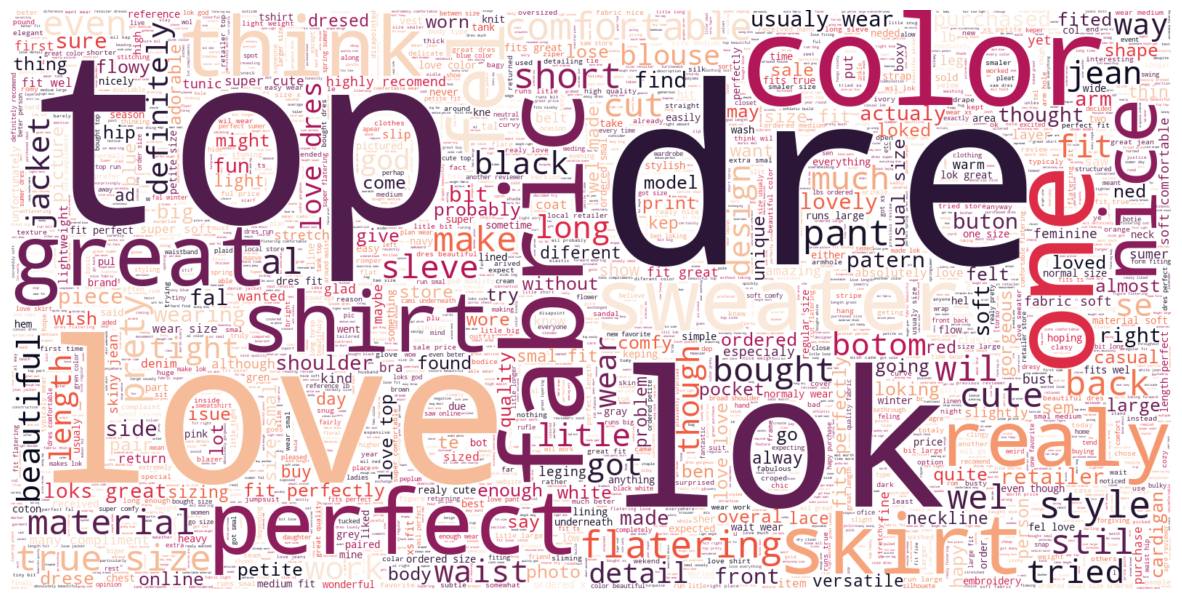

In [31]:
plt.figure(figsize=(15,15))
# Text that is recommended
wc = WordCloud(width=1600, height=800, max_words=3000, colormap='rocket', background_color='white').generate(" ".join(df[df.recommended_ind == 'Recommended'].review_text))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<h4>Most Common Words in Not Recommended Review</h4>

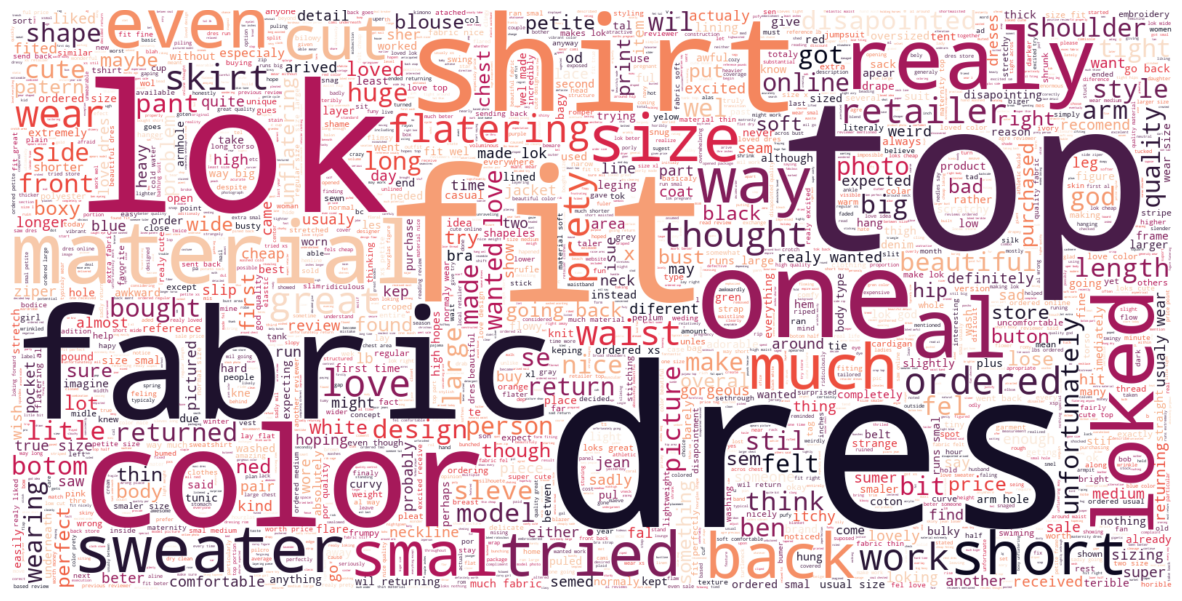

In [32]:
plt.figure(figsize=(15,15))
# Text that is not recommended
wc = WordCloud(width=1600, height=800, max_words=3000, colormap='rocket', background_color='white').generate(" ".join(df[df.recommended_ind == 'Not Recommended'].review_text))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## 5. Sentiment Analysis

After cleaning and preprocessing the text, I am performing sentiment analysis on the `review_text` column that includes all customer reviews. I am classifying the reviews into three categories: Positive, Negative, and Neutral, and also creating a new column called compound in order to store the polarity score for each review. Reviews with a polarity score greater than 0.8 are classified as Positive, between 0.4 and 0.8 as Neutral, and less than 0.4 as Negative, I chose these thresholds because even some of the reviews in `Not-Recommended` category are classified as Negative when I choose lower threshold. This way, I can make sure that the negative sentiments are recorded correctly.<br>
Finally, I am visualizing the sentiment analysis results; due to imbalanced data and having less observations in the `Not-Recommended` category, I am still getting fewer information about the negative sentiment despite introducing a higher threshold.


In [33]:
# Import the SentimentIntensityAnalyzer class from the vaderSentiment module
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentiment = SentimentIntensityAnalyzer()

# Apply the polarity_scores method to get the polarity scores for each review
df['review_text'].apply(lambda x: sentiment.polarity_scores(x))

0        {'neg': 0.0, 'neu': 0.154, 'pos': 0.846, 'comp...
1        {'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'comp...
2        {'neg': 0.037, 'neu': 0.698, 'pos': 0.264, 'co...
3        {'neg': 0.171, 'neu': 0.185, 'pos': 0.644, 'co...
4        {'neg': 0.0, 'neu': 0.655, 'pos': 0.345, 'comp...
                               ...                        
23481    {'neg': 0.123, 'neu': 0.468, 'pos': 0.409, 'co...
23482    {'neg': 0.121, 'neu': 0.621, 'pos': 0.258, 'co...
23483    {'neg': 0.1, 'neu': 0.563, 'pos': 0.338, 'comp...
23484    {'neg': 0.048, 'neu': 0.598, 'pos': 0.355, 'co...
23485    {'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...
Name: review_text, Length: 22628, dtype: object

In [34]:
df['polarity_score'] = df['review_text'].apply(lambda x: sentiment.polarity_scores(x)['compound'])
df['neutral'] = df['review_text'].apply(lambda x: sentiment.polarity_scores(str(x))['neu'])
df['negative'] = df['review_text'].apply(lambda x: sentiment.polarity_scores(str(x))['neg'])
df['positive'] = df['review_text'].apply(lambda x: sentiment.polarity_scores(str(x))['pos'])


In [35]:
# Classify the reviews into sentiment categories based on the polarity score thresholds
df['sentiment']=''
df.loc[df.polarity_score>0.8,'sentiment']='Positive'
df.loc[(df.polarity_score>0.4) & (df.polarity_score<0.8),'sentiment']='Neutral'
df.loc[df.polarity_score<0.4,'sentiment']='Negative'


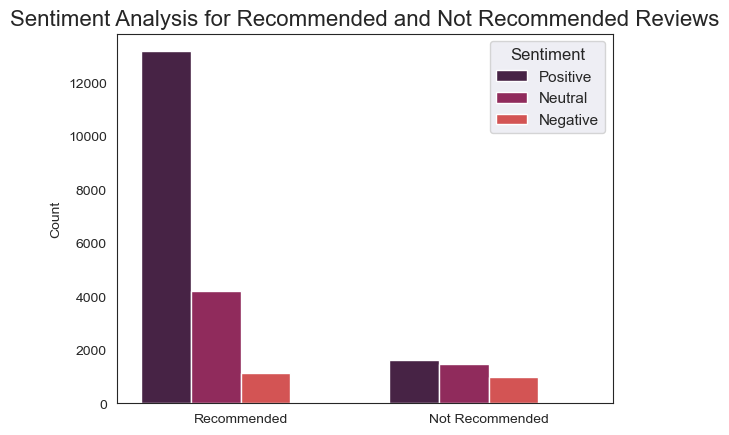

In [36]:
sns.set_style('white')
sns.countplot(x='recommended_ind', hue='sentiment', data=df, palette='rocket')
sns.set(rc={'figure.figsize':(16,5)})
plt.xlabel('')
plt.ylabel('Count')
plt.title('Sentiment Analysis for Recommended and Not Recommended Reviews', fontsize=16)
plt.legend(title='Sentiment', loc='upper right')
plt.show()

## 6. Modelling using Multinomial Naive Bayes

I am spliting the data into train and test, with 80 and 20 proportion respectively. After creating the pipeline and fitting a Naive Bayes model, we can see that the model achieved an accuracy of 0.90 on the test set, with precision and recall of 0.71 and 0.72 for the "Not Recommended" class and 0.94 and 0.93 for the "Recommended" class, respectively. The F1-score for the "Not Recommended" class was 0.72 and for the "Recommended" class, it was 0.94. The macro-average of precision, recall, and F1-score was 0.82, while the weighted average was 0.90. Overall, the model performed well in predicting both classes, but there is room for improvement in predicting the "Not Recommended" class.

In [37]:
text_train, text_test, recommend_train, recommend_test = train_test_split(df['review_text'], df['recommended_ind'], test_size=0.2, random_state=160323, stratify=df['recommended_ind'])

In [38]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=None)),
    ('nb', MultinomialNB(class_prior = [0.3, 0.7]))
])

pipeline.fit(text_train, recommend_train)

predictions = pipeline.predict(text_test)

print(classification_report(recommend_test, predictions))

                 precision    recall  f1-score   support

Not Recommended       0.71      0.72      0.72       820
    Recommended       0.94      0.93      0.94      3706

       accuracy                           0.90      4526
      macro avg       0.82      0.83      0.83      4526
   weighted avg       0.90      0.90      0.90      4526



## 7. Logistic Regression

The second model (Logistic Regression) achieved an accuracy of 0.89 on the test set, with precision and recall of 0.71 and 0.64 for the "Not Recommended" class and 0.92 and 0.94 for the "Recommended" class, respectively. The F1-score for the "Not Recommended" class was 0.67 and for the "Recommended" class, it was 0.93. The macro-average of precision, recall, and F1-score was 0.81, while the weighted average was 0.88. The model performed slightly worse in predicting the "Not Recommended" class as compared to the Naive Bayes model, but it performed similarly for the "Recommended" class.

In [39]:
# create a logistic regression model
lr = LogisticRegression()

# create a pipeline with TF-IDF vectorization and logistic regression
pipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=None)),
    ('lr', lr)
])
pipeline.fit(text_train, recommend_train)

predictions = pipeline.predict(text_test)

print(classification_report(recommend_test, predictions))

/Users/shahanaayobi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                 precision    recall  f1-score   support

Not Recommended       0.71      0.64      0.67       820
    Recommended       0.92      0.94      0.93      3706

       accuracy                           0.89      4526
      macro avg       0.81      0.79      0.80      4526
   weighted avg       0.88      0.89      0.88      4526



## 8. Stemming the Text
The new results for the Naive Bayes and Logistic Regression models with stemming show a slight decrease in performance as compared to the previous models without stemming. The Naive Bayes model achieved an accuracy of 0.89, with precision and recall of 0.67 and 0.73 for the "Not Recommended" class, and 0.94 and 0.92 for the "Recommended" class, respectively. The Logistic Regression model achieved an accuracy of 0.89, with precision and recall of 0.72 and 0.62 for the "Not Recommended" class, and 0.92 and 0.95 for the "Recommended" class, respectively.<br>

Stemming is not a good idea in this context because it can cause the loss of important information that may affect the accuracy of the classification model. Stemming reduces words to their root form, which can lead to the loss of information about the original word, including its context, tense, and meaning

In [40]:
stopword_list=nltk.corpus.stopwords.words('english')
def stemming_text(text):
    words = word_tokenize(text.lower())
    tokens = [word for word in words if word not in string.punctuation]
    tokens = [token for token in tokens if token not in  stopword_list]
    stemmer = LancasterStemmer()
    tokens_stemmed = [stemmer.stem(word) for word in tokens]
    preprocessed_text = ' '.join(tokens_stemmed)
    return preprocessed_text

#### Naive Bayes with Stemming

In [41]:
pipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=stemming_text)),
    ('nb', MultinomialNB())
])

pipeline.fit(text_train, recommend_train)

predictions = pipeline.predict(text_test)

print(classification_report(recommend_test, predictions))


                 precision    recall  f1-score   support

Not Recommended       0.72      0.67      0.69       820
    Recommended       0.93      0.94      0.93      3706

       accuracy                           0.89      4526
      macro avg       0.82      0.81      0.81      4526
   weighted avg       0.89      0.89      0.89      4526



#### Logistic Regression with Stemming

In [42]:
# create a pipeline with TF-IDF vectorization and logistic regression
pipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=stemming_text)),
    ('lr', lr)
])
pipeline.fit(text_train, recommend_train)

predictions = pipeline.predict(text_test)

print(classification_report(recommend_test, predictions))

/Users/shahanaayobi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                 precision    recall  f1-score   support

Not Recommended       0.72      0.62      0.67       820
    Recommended       0.92      0.95      0.93      3706

       accuracy                           0.89      4526
      macro avg       0.82      0.79      0.80      4526
   weighted avg       0.88      0.89      0.88      4526



## 9. Conclusion

In summary, I evaluated two classification models - Naive Bayes and Logistic Regression - on a dataset of customer reviews with and without stemming. The models were trained using scikit-learn's Pipeline API, and their performance was evaluated using classification metrics. The Naive Bayes and Logistic Regression models without stemming achieved higher accuracy, precision, recall, and F1-scores for both classes as compared to the models with stemming. For further analysis, the Multinomial Naive Bayes model is recommended as it achieved higher accuracy, precision, recall, and F1-scores for both classes as compared to the Logistic Regression model. Therefore, it appears to be a better choice for predicting the recommendation status of reviews.